Encoder part, use wav2vec2 as a example.


In [1]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2PhonemeCTCTokenizer
import torch
import torchaudio
import json
from IPython.display import Audio,display

In [2]:
# Load your audio file
speaker = "p088_4067"
audio_input = f"data/audio/{speaker}.wav"

ref_text = f'data/gt_text/{speaker}.txt'

waveform, sample_rate = torchaudio.load(audio_input)
with open(ref_text, 'r') as f:
    ref_text = f.read()

display(Audio(audio_input))
print(f"Sample rate: {sample_rate}")
print(f'ref_text: {ref_text}')

Sample rate: 22050
ref_text: They left early


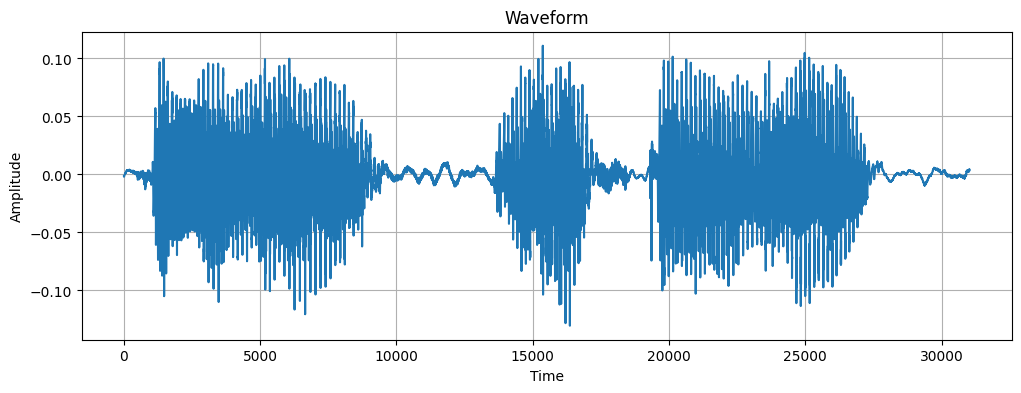

In [12]:
# plot the waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [3]:
# Load pre-trained Wav2Vec 2.0 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xlsr-53-phon-cv-ft")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xlsr-53-phon-cv-ft")
device = "cuda:1" if torch.cuda.is_available() else "cpu"

# Resample audio to match the model's expected input sample rate (16kHz for Wav2Vec 2.0)
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

# Ensure waveform is in the correct shape for Wav2Vec 2.0 (expecting shape [batch_size, sequence_length])
# Wav2Vec 2.0 expects the input tensor to be 2D (batch_size, sequence_length)
# Add a batch dimension (1, seq_len) if necessary
waveform = waveform.squeeze()  # Remove the extra dimension if present (channels, time) => (time,)
input_values = processor(waveform, return_tensors="pt", device=device, sampling_rate=16000).input_values

# Get logits from the model
with torch.no_grad():
    logits = model(input_values).logits
    print(f'logits shape: {logits.shape}')

logits shape: torch.Size([1, 96, 272])


Decoding with WFST


In [4]:
from utils.fst import WFSTdecoder
from utils.wper import W_PER
import json
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


In [5]:
# config
device = 'cpu' # only support cpu for now because of k2 framework
phoneme_lexicon = json.load(open('config/lexicon.json'))
ipa2cmu = json.load(open('config/ipa2cmu.json', 'r'))
is_ipa = True

def ipa_to_cmu(ipa_list):
    cmu_list = []
    for ipa in ipa_list:
        if ipa in ipa2cmu:
            cmu_value = ipa2cmu[ipa].split()[0]
            cmu_list.append(cmu_value)
        else:
            continue
            # cmu_list.append(f"<UNK:{ipa}>")
    return cmu_list



# build WFST decoder
decoder = WFSTdecoder(device=device, 
                      phoneme_lexicon=phoneme_lexicon,
                      phn_type="ipa")

construct decoder and dataloader


In [6]:
class MetadataDataset(Dataset):
    def __init__(self, meta_data):
        self.meta_data = meta_data

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        sample_id, _, _ = self.meta_data[idx]
        tensor = self.meta_data[idx]["tensor"]
        ref_text = self.meta_data[idx]["ref_text"]
        
        return {"id": sample_id, "tensor": tensor, "ref_text": ref_text}
    
# @staticmethod
def collate_fn(batch):
    """Custom collate function to handle variable-length tensors."""
    ids = [item["id"] for item in batch]
    ref_texts = [item["ref_text"] for item in batch]
    tensors = [item["tensor"].squeeze(0) for item in batch]
    lengths = torch.tensor([t.size(0) for t in tensors], dtype=torch.int32)

    # Pad tensors to match lengths
    padded_tensors = pad_sequence(tensors, batch_first=True)

    return {"id": ids, "tensor": padded_tensors, "ref_text": ref_texts, "lengths": lengths}

meta_data = [{
'id': speaker,
'tensor': logits,
'ref_text': ref_text
}]

dataset = MetadataDataset(meta_data)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

for batch in dataloader:
    result = decoder.decode(batch, beta=5, num_beam=25,back=True,skip=False)[0]
    
print(result.keys())

dict_keys(['id', 'ref_phonemes', 'dys_detect', 'decode_phonemes', 'lattice'])


In [7]:
print(f"ref_text: {ipa_to_cmu(result['ref_phonemes'])}")
print(f"Prediction: {ipa_to_cmu(result['decode_phonemes'])}")

ref_text: ['DH', 'EY', 'IH', 'L', 'EH', 'F', 'T', 'AH', 'R', 'L', 'IY']
Prediction: ['DH', 'EY', 'IH', 'L', 'IH', 'L', 'EH', 'F', 'T', 'AH', 'R', 'L', 'IY']


In [8]:
print(type(result['lattice']))

<class 'k2.fsa.Fsa'>


In [9]:
print(result['decode_phonemes'])

['ð', 'e', 'ɪ', 'l', 'ɪ', 'l', 'ɛ', 'f', 't', 'ə', 'r', 'l', 'i']


In [13]:
def get_dys(item, type='repetition'):
    result = []
    for i, val in enumerate(item):
        if val['dysfluency_type'] == type:
            print(i)
            result.append(val['phoneme'])

    return result

rep_detect = get_dys(result['dys_detect'], type='repetition')
rep_detect = ipa_to_cmu(rep_detect)

print(f"Repetition: {rep_detect}")

4
5
Repetition: ['IH', 'L']
